# Preparation

In [1]:
# Get required resources
import numpy as np
from datetime import datetime
from keras.utils import np_utils
from tensorflow import set_random_seed

%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Activation, Dropout, LSTM, AveragePooling1D, Bidirectional, TimeDistributed, Flatten, Permute, Reshape, multiply, Lambda, RepeatVector, LeakyReLU, Concatenate, Masking
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam

from keras import backend as K

time_stamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

np.random.seed(1234)
set_random_seed(1234)

Using TensorFlow backend.


In [2]:
dataset = np.load("data/dataset_chunk3.serialized.npy")
authors = np.load("data/authors_chunk3.serialized.npy")

In [3]:
dataset["input"].shape

(98473, 75, 301)

In [5]:
nb_samples = len(dataset)
n_authors = len(authors)

valid_split = 0.2
test_split = 0.1

In [6]:
#shuffle the dataset
np.random.shuffle(dataset)

In [7]:
# train-valid-test split and one-hot encoding (dataset prep)
#input
X_train = dataset['input'][0:int(nb_samples*(1-valid_split-test_split))]
X_valid = dataset['input'][int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
X_test  = dataset['input'][int(nb_samples*(1-test_split)):]

#output
Y_train = dataset['output'][0:int(nb_samples*(1-valid_split-test_split))]
Y_valid = dataset['output'][int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
Y_test  = dataset['output'][int(nb_samples*(1-test_split)):]

# one hot encoding
Y_train = np_utils.to_categorical(Y_train, n_authors)
Y_valid = np_utils.to_categorical(Y_valid, n_authors)
Y_test = np_utils.to_categorical(Y_test, n_authors)

In [8]:
def plot_history(network_history, filename):
    
    #set pltting attributes
    #loss-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.savefig(filename + '_loss.jpg')

    #accuracy-epochs
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.savefig(filename + '_acc.jpg')
    
    plt.show()

In [9]:
def evaluate_model(model, network_history, filename):
  #plot learning history
  plot_history(network_history, filename)

  # Final evaluation of the model
  scores = model.evaluate(X_test, Y_test, verbose=0)
  print("Test accuracy: %.2f%%" % (scores[2]*100))

In [10]:
def show_predictions(model):
  predictions = model.predict(X_test)
  
  print("%-25s %s" % ("Prediction", "Real author"))
  print("="*45)
  for i in range(0, len(predictions)):
    print("%-25s %s" % (authors[np.argmax(predictions[i])], authors[np.argmax(Y_test[i])]))
    print("-"*45)

# NeuralNetworks

In [11]:
def generate_simple_lstm_model(input_shape, n_neurons, dropout, recurrent_dropout):
  model = Sequential()

  #we add an lstm layer with a decent dropout
  model.add(LSTM(n_neurons, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True, input_shape=input_shape))
  model.add(TimeDistributed(Dense(100)))
  model.add(AveragePooling1D())

  model.add(Flatten())

  model.add(Dense(n_authors, activation="softmax"))
  
  return model

In [12]:
def generate_simple_bilstm_model(input_shape, n_neurons, dropout, recurrent_dropout):
  model = Sequential()

  #we add an lstm layer with a decent dropout
  model.add(Bidirectional(LSTM(n_neurons, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True), input_shape=input_shape, merge_mode="sum"))
  model.add(TimeDistributed(Dense(100)))
  model.add(AveragePooling1D())

  model.add(Flatten())

  model.add(Dense(n_authors, activation="softmax"))
  
  return model

In [13]:
def generate_own_lstm_model(input_shape, n_neurons, dropout, recurrent_dropout):
  inputs = Input(shape=input_shape)

  lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(
      LSTM(
          n_neurons, 
          dropout=dropout, 
          recurrent_dropout=recurrent_dropout, 
          return_sequences=True, 
          return_state=True
      ), 
      merge_mode="sum"
  )(inputs)

  # TimeDistributedMerge with sum to higher peaks and lower valleys - indicate the important parts
  lstm = Lambda(lambda x: K.sum(x, axis=1))(lstm)

  # the input of the fully connected part can learn from all 3 "predictions"
  x = Concatenate()([lstm, forward_h, backward_h])

  predictions = Dense(len(authors), activation="softmax")(x)

  return Model(inputs=inputs, outputs=predictions)

# NeuralNetwork tester

In [14]:
test_counter = 0
test_dir = 'tests_' + time_stamp + '/'

In [15]:
%%bash -s "$test_dir"
mkdir $1

RUN THIS BEFORE EVERY NEW TEST:

In [16]:
test_counter += 1

# test parameters
batch_size = 1024
n_neurons = 256
dropout = 0.4
recurrent_dropout = 0.2

# reset and reparameterize the callbacks
# save the logs
csv_logger = CSVLogger(test_dir + 'history_log' + str(test_counter) + '.csv', append=True, separator=';')

#setup early stopping
es = EarlyStopping(patience=5, verbose=1, min_delta=0.005)

#we are going to keep only the best model
mcp = ModelCheckpoint(filepath=test_dir + 'weights' + str(test_counter) + '.hdf5', verbose=1, save_best_only=True)


# generate the model for testing with the given parameters
model = generate_own_lstm_model(X_train[0].shape, n_neurons, dropout, recurrent_dropout)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 301)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 75, 256), (N 1142784     input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256)          0           bidirectional_1[0][0]            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 768)          0           lambda_1[0][0]                   
                                                                 bidirectional_1[0][1]            
          

In [17]:
# set parameters and start learning
history = model.fit(X_train, Y_train, 
          batch_size=batch_size, 
          epochs=100000, # early stopping
          verbose=1, 
          validation_data=(X_valid, Y_valid), 
          shuffle=True,
          callbacks=[mcp, es, csv_logger]
         )

Train on 68931 samples, validate on 19694 samples
Epoch 1/100000
68931/68931 [==============================] - 68s 981us/step - loss: 4.9297 - mean_absolute_error: 0.0319 - acc: 0.2495 - val_loss: 1.9675 - val_mean_absolute_error: 0.0249 - val_acc: 0.5220

Epoch 00001: val_loss improved from inf to 1.96748, saving model to tests_2018-12-09_10-35-38/weights1.hdf5
Epoch 2/100000
68931/68931 [==============================] - 34s 494us/step - loss: 2.1288 - mean_absolute_error: 0.0256 - acc: 0.4727 - val_loss: 1.6768 - val_mean_absolute_error: 0.0222 - val_acc: 0.5896

Epoch 00002: val_loss improved from 1.96748 to 1.67675, saving model to tests_2018-12-09_10-35-38/weights1.hdf5
Epoch 3/100000
68931/68931 [==============================] - 34s 487us/step - loss: 1.7073 - mean_absolute_error: 0.0232 - acc: 0.5432 - val_loss: 1.2492 - val_mean_absolute_error: 0.0207 - val_acc: 0.6339

Epoch 00003: val_loss improved from 1.67675 to 1.24921, saving model to tests_2018-12-09_10-35-38/weights1

In [18]:
# load back best model (early stopping + model checkpoint)
model = load_model(test_dir + 'weights' + str(test_counter) + '.hdf5')

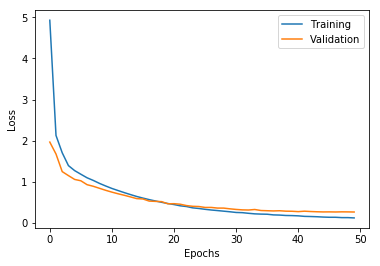

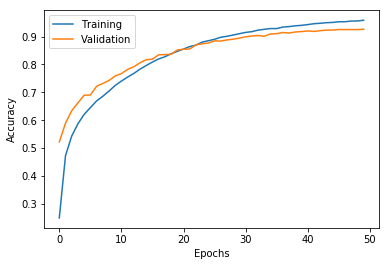

Test accuracy: 92.95%


In [19]:
evaluate_model(model, history, test_dir + 'plot' + str(test_counter))

In [20]:
show_predictions(model)

Prediction                Real author
EricAuchard               EricAuchard
---------------------------------------------
NickLouth                 NickLouth
---------------------------------------------
LydiaZajc                 LydiaZajc
---------------------------------------------
FumikoFujisaki            FumikoFujisaki
---------------------------------------------
RobinSidel                RobinSidel
---------------------------------------------
MatthewBunce              MatthewBunce
---------------------------------------------
MichaelConnor             MichaelConnor
---------------------------------------------
JonathanBirt              JonathanBirt
---------------------------------------------
BradDorfman               BradDorfman
---------------------------------------------
FumikoFujisaki            FumikoFujisaki
---------------------------------------------
KouroshKarimkhany         KouroshKarimkhany
---------------------------------------------
SamuelPerry               S